# Satellite Image Segmentation - REST API

Berkeley Image Seg is a region merging image object segmentation algorithm  
Give it multiband satellite imagery and it returns an int image labeled with object IDs 

https://github.com/jscarbor/bis  
www.imageseg.com  jscar@berkenviro.com

In [1]:
import numpy as np
import requests
import rasterio

%matplotlib inline
from matplotlib import pyplot as plt
from rasterio.plot import show

endpoint = 'http://localhost:8080/v1/segment'
# endpoint = 'https://api.imageseg.com/v1/segment'

### Sample RGB image
With no georeferencing

In [2]:
dataset = rasterio.open('agé.bmp')
dataset.profile

/Users/jscar/PycharmProjects/cloudrun/venv/lib/python3.7/site-packages/rasterio/__init__.py:219: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


{'driver': 'BMP', 'dtype': 'uint8', 'nodata': None, 'width': 212, 'height': 127, 'count': 3, 'crs': None, 'transform': Affine(1.0, 0.0, 0.0,
       0.0, 1.0, 0.0), 'tiled': False}

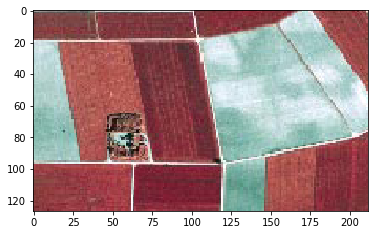

In [3]:
ax = show(dataset.read())

### Segment the image using the REST API

In [4]:
r = requests.post(endpoint, files={'file': open('agé.bmp', 'rb')})
regions = rasterio.io.MemoryFile(r.content).open().read(1)
regions.shape

(127, 212)

In [5]:
regions

array([[310, 310, 310, ..., 328, 328, 336],
       [334, 334, 334, ..., 328, 328, 336],
       [293, 293, 293, ..., 328, 328, 328],
       ...,
       [  0,   0,   0, ...,  20,  20,  20],
       [  0,   0,   0, ...,  20,  20,  20],
       [  0,   0,   0, ...,  20,  20,  20]], dtype=int32)

In [6]:
regions.max() + 1  # Total number of image objects

338

### Show objects by color

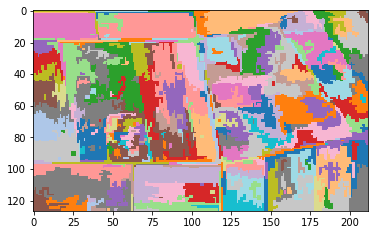

In [7]:
np.random.seed(0)
lookups = np.random.rand(regions.size)
cmap = plt.cm.colors.ListedColormap(plt.cm.tab20(lookups))

ax = show(regions, cmap=cmap)

### Plot objects as polygons

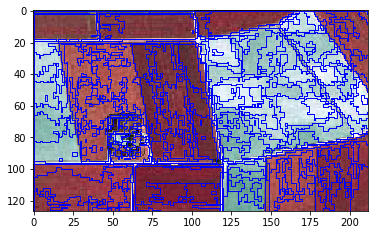

In [8]:
from rasterio import features
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection

coords, labels = zip(*[(shape['coordinates'][0], int(label))
                        for shape, label in features.shapes(regions)])
polys = [Polygon(coord, closed=True) for coord in coords]
collection = PatchCollection(polys, edgecolor='blue', facecolor='none')

fig, ax = plt.subplots()
ax.add_collection(collection)
show(dataset.read())
plt.show()

### Classify the image objects
Basic unsupervised clustering using spectral properties  
Compute the mean value of each band for each object  
Use those band averages as the features for classification

In [17]:
rgb = dataset.read()
rgbs = np.asarray([rgb[...,regions == label].mean(axis=1)
                   for label in labels])
rgbs

array([[208.05882353, 204.5       , 203.02941176],
       [225.5       , 189.5       , 177.5       ],
       [ 92.        ,  87.22857143,  84.54285714],
       ...,
       [122.40883978,  44.55248619,  54.62430939],
       [148.60069444,  60.62384259,  66.78703704],
       [162.43478261,  75.18060201,  73.49498328]])

In [18]:
from sklearn.cluster import KMeans
classes = KMeans(n_clusters=2, random_state=0).fit_predict(rgbs)
classes

array([0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0,
       1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1,
       0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,

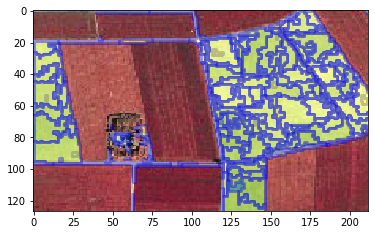

In [19]:
classpolys = [poly for class_, poly in zip(classes, polys) if class_ == 0]
collection = PatchCollection(classpolys, edgecolor='blue', facecolor='yellow',
                             alpha=0.4, linewidth=3)

fig, ax = plt.subplots()
ax.add_collection(collection)
show(dataset.read())
plt.show()